In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from oasis.functions import deconvolve
from scipy.stats import pearsonr

from utils.context_data_csv import ContextDataCSV
from utils.matrix_optimizer import MatrixOptimizer

import utils.sulfur.constant as const

/app/OASIS/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [2]:
engram_shock_cells = {
    'ID181106CreA': ['C261', 'C305', 'C347', 'C349', 'C351'],
    'ID181106CreB': ['C058', 'C089', 'C126'],
    'ID181106CreC': ['C017', 'C065', 'C112', 'C117', 'C203', 'C227'],
    'ID181106CreG': ['C127', 'C239', 'C323', 'C347', 'C350', 'C399', 'C402'],
    'ID181106CreH': ['C164', 'C180', 'C184', 'C243', 'C253', 'C298', 'C327', 'C351', 'C534', 'C542'],
    'ID181106CreI': ['C136', 'C197', 'C273', 'C292', 'C294', 'C306', 'C333'],
    'ID181106CreK': ['C083', 'C088', 'C100', 'C149', 'C390'],
    'ID181106CreL': ['C200'],
    'ID181106CreN': ['C199', 'C255', 'C258', 'C273'],
    'ID181106CreQ': ['C393']
}

non_engram_shock_cells = {
    'ID181106CreA': ['C000', 'C007', 'C009', 'C059', 'C076', 'C084', 'C086', 'C099', 'C101', 'C116', 'C120', 'C124', 'C141', 'C143', 'C145', 'C153', 'C164', 'C173', 'C175', 'C197', 'C198', 'C228', 'C234', 'C235', 'C284', 'C303', 'C306', 'C310', 'C317', 'C325', 'C327', 'C328', 'C336', 'C362', 'C377', 'C442', 'C459', 'C476', 'C479', 'C480', 'C487', 'C491', 'C493', 'C494', 'C519'],
    'ID181106CreB': ['C000', 'C003', 'C009', 'C010', 'C063', 'C066', 'C071', 'C072', 'C073', 'C080', 'C083', 'C088', 'C090', 'C094', 'C100', 'C103', 'C108', 'C109', 'C112', 'C114', 'C115', 'C127', 'C130', 'C131', 'C134', 'C166', 'C168', 'C169', 'C177', 'C178', 'C179', 'C200', 'C202', 'C203', 'C213', 'C230', 'C231', 'C268', 'C279', 'C282', 'C284'],
    'ID181106CreC': ['C002', 'C011', 'C012', 'C016', 'C019', 'C043', 'C045', 'C049', 'C050', 'C054', 'C055', 'C056', 'C058', 'C060', 'C063', 'C070', 'C072', 'C074', 'C076', 'C079', 'C084', 'C086', 'C088', 'C096', 'C105', 'C107', 'C118', 'C127', 'C132', 'C143', 'C144', 'C146', 'C153', 'C155', 'C160', 'C168', 'C186', 'C192', 'C193', 'C194', 'C198', 'C202', 'C205', 'C215', 'C219', 'C224', 'C233', 'C235', 'C237', 'C238', 'C239', 'C241', 'C256', 'C257', 'C262', 'C268', 'C272', 'C276', 'C287', 'C294', 'C295', 'C296'],
    'ID181106CreG': ['C003', 'C004', 'C005', 'C010', 'C011', 'C017', 'C025', 'C063', 'C067', 'C070', 'C071', 'C073', 'C076', 'C089', 'C102', 'C118', 'C126', 'C133', 'C136', 'C142', 'C157', 'C166', 'C177', 'C193', 'C197', 'C199', 'C204', 'C205', 'C210', 'C212', 'C229', 'C232', 'C244', 'C247', 'C249', 'C253', 'C261', 'C273', 'C286', 'C291', 'C293', 'C294', 'C298', 'C302', 'C304', 'C305', 'C309', 'C313', 'C325', 'C338', 'C344', 'C352', 'C353', 'C361', 'C377', 'C385', 'C426', 'C449', 'C458', 'C478'],
    'ID181106CreH': ['C018', 'C021', 'C059', 'C074', 'C081', 'C085', 'C087', 'C125', 'C127', 'C148', 'C160', 'C175', 'C203', 'C218', 'C232', 'C249', 'C252', 'C256', 'C261', 'C268', 'C271', 'C350', 'C361', 'C385', 'C386', 'C395', 'C397', 'C400', 'C404', 'C411', 'C475', 'C490', 'C493', 'C497', 'C498', 'C505', 'C511', 'C520', 'C521', 'C525', 'C529', 'C541', 'C579', 'C594', 'C603', 'C632', 'C636'],
    'ID181106CreI': ['C012', 'C049', 'C061', 'C143', 'C164', 'C166', 'C176', 'C183', 'C214', 'C249', 'C254', 'C256', 'C270', 'C275', 'C281', 'C302', 'C325', 'C326', 'C327', 'C341', 'C352', 'C368'],
    'ID181106CreK': ['C006', 'C045', 'C066', 'C071', 'C075', 'C080', 'C085', 'C102', 'C114', 'C117', 'C123', 'C124', 'C133', 'C136', 'C145', 'C178', 'C180', 'C202', 'C205', 'C206', 'C207', 'C208', 'C233', 'C238', 'C239', 'C243', 'C251', 'C262', 'C267', 'C277', 'C291', 'C297', 'C323', 'C325', 'C341', 'C352', 'C361', 'C376', 'C380', 'C399', 'C403', 'C411', 'C424', 'C428'],
    'ID181106CreL': ['C008', 'C015', 'C020', 'C021', 'C037', 'C040', 'C044', 'C049', 'C061', 'C069', 'C073', 'C074', 'C075', 'C082', 'C085', 'C123', 'C125', 'C126', 'C128', 'C129', 'C132', 'C133', 'C144', 'C150', 'C155', 'C162', 'C173', 'C180', 'C185', 'C196', 'C203', 'C209', 'C211', 'C213', 'C216', 'C224', 'C231', 'C236', 'C243', 'C255', 'C270', 'C273', 'C283', 'C298', 'C312', 'C315', 'C323', 'C332', 'C341', 'C343', 'C344', 'C346', 'C350', 'C353', 'C357', 'C373', 'C414', 'C416', 'C424', 'C439', 'C445', 'C456', 'C461', 'C463', 'C475', 'C498', 'C501'],
    'ID181106CreN': ['C008', 'C022', 'C028', 'C044', 'C048', 'C057', 'C062', 'C069', 'C079', 'C089', 'C098', 'C123', 'C144', 'C168', 'C186', 'C201', 'C204', 'C213', 'C217', 'C227', 'C228', 'C239', 'C261', 'C267', 'C288', 'C290', 'C301', 'C306', 'C309', 'C321', 'C343', 'C355', 'C391', 'C395', 'C397', 'C402', 'C404', 'C410', 'C412', 'C413', 'C416', 'C425', 'C429', 'C441', 'C463', 'C469', 'C490', 'C506', 'C511', 'C517'],
    'ID181106CreQ': ['C000', 'C001', 'C006', 'C009', 'C019', 'C022', 'C033', 'C034', 'C040', 'C042', 'C050', 'C055', 'C057', 'C059', 'C061', 'C070', 'C076', 'C089', 'C092', 'C098', 'C108', 'C118', 'C121', 'C122', 'C123', 'C127', 'C132', 'C134', 'C137', 'C168', 'C169', 'C173', 'C179', 'C181', 'C192', 'C202', 'C205', 'C207', 'C209', 'C214', 'C217', 'C239', 'C260', 'C263', 'C281', 'C284', 'C305', 'C308', 'C316', 'C325', 'C332', 'C333', 'C335', 'C336', 'C343', 'C347', 'C354', 'C362', 'C365', 'C368', 'C372', 'C374', 'C375', 'C380', 'C387', 'C398', 'C412', 'C417', 'C421', 'C426', 'C431', 'C434', 'C455', 'C456', 'C463', 'C464', 'C470', 'C485', 'C491']
}

In [3]:
all_shock_cells = {}
for animal_name in engram_shock_cells:
    all_shock_cells[animal_name] = engram_shock_cells[animal_name] + non_engram_shock_cells[animal_name]
    
all_shock_cells

{'ID181106CreA': ['C261',
  'C305',
  'C347',
  'C349',
  'C351',
  'C000',
  'C007',
  'C009',
  'C059',
  'C076',
  'C084',
  'C086',
  'C099',
  'C101',
  'C116',
  'C120',
  'C124',
  'C141',
  'C143',
  'C145',
  'C153',
  'C164',
  'C173',
  'C175',
  'C197',
  'C198',
  'C228',
  'C234',
  'C235',
  'C284',
  'C303',
  'C306',
  'C310',
  'C317',
  'C325',
  'C327',
  'C328',
  'C336',
  'C362',
  'C377',
  'C442',
  'C459',
  'C476',
  'C479',
  'C480',
  'C487',
  'C491',
  'C493',
  'C494',
  'C519'],
 'ID181106CreB': ['C058',
  'C089',
  'C126',
  'C000',
  'C003',
  'C009',
  'C010',
  'C063',
  'C066',
  'C071',
  'C072',
  'C073',
  'C080',
  'C083',
  'C088',
  'C090',
  'C094',
  'C100',
  'C103',
  'C108',
  'C109',
  'C112',
  'C114',
  'C115',
  'C127',
  'C130',
  'C131',
  'C134',
  'C166',
  'C168',
  'C169',
  'C177',
  'C178',
  'C179',
  'C200',
  'C202',
  'C203',
  'C213',
  'C230',
  'C231',
  'C268',
  'C279',
  'C282',
  'C284'],
 'ID181106CreC': ['C017',


In [4]:
animal_name = const.ANIMAL_NAMES[0]
a1_csv = ContextDataCSV(animal_name, 'A1postES')
a1_matrix = MatrixOptimizer(a1_csv.data_frame).divide_sd()

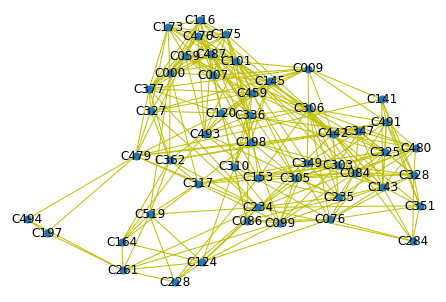

In [5]:
graph = nx.Graph()

shock_cells_per_animal = all_shock_cells[animal_name]
preserved_spikes = {}
for i in range(len(shock_cells_per_animal)):
    base_shock_cell = shock_cells_per_animal[i]
    
    base_spikes = None
    if base_shock_cell in preserved_spikes:
        base_spikes = preserved_spikes[base_shock_cell]
    else:
        base_values = a1_matrix.loc[:, base_shock_cell]
        _c, base_spikes, _b, _g, _lam = deconvolve(base_values.to_numpy(), g=(None, None), penalty=1)
        base_spikes[base_spikes <= 0.05] = 0.0
        
    if not base_shock_cell in preserved_spikes:
        preserved_spikes[base_shock_cell] = base_spikes
        
    base_spikes = base_spikes[80:100]
    
    for j in range(i + 1, len(shock_cells_per_animal)):
        compared_shock_cell = shock_cells_per_animal[j]
        
        compared_spikes = None
        if compared_shock_cell in preserved_spikes:
            compared_spikes = preserved_spikes[compared_shock_cell]
        else:
            compared_values = a1_matrix.loc[:, compared_shock_cell]
            _c, compared_spikes, _b, _g, _lam = deconvolve(compared_values.to_numpy(), g=(None, None), penalty=1)
            compared_spikes[compared_spikes <= 0.05] = 0.0
            
        if not compared_shock_cell in preserved_spikes:
            preserved_spikes[compared_shock_cell] = compared_spikes
            
        compared_spikes = compared_spikes[80:100]
        
        r, _ = pearsonr(base_spikes, compared_spikes)
        
        if r >= 0.1:
            if base_shock_cell not in graph.nodes:
                graph.add_node(base_shock_cell)
            graph.add_edge(base_shock_cell, compared_shock_cell, weight=r, length=1.0/r)
        
nx.draw_spring(graph, node_size=len(shock_cells_per_animal), edge_color='y', with_labels=True)
adjacency_matrix = pd.DataFrame(nx.adjacency_matrix(graph).toarray())

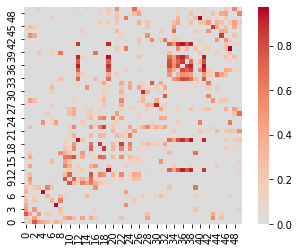

In [6]:
ax = sns.heatmap(adjacency_matrix, square=True, cmap='coolwarm', center=0.0)
ax.invert_yaxis()

In [7]:
values = []
adjancency_matrix = nx.adjacency_matrix(graph).toarray()
for i, arr in enumerate(adjancency_matrix):
    if i == len(adjancency_matrix) - 1:
        continue
    
    values.extend(arr[i+1:])
    
values

[0.21050895646535084,
 0.7471594187862322,
 0.4856323958784489,
 0.3915352275013318,
 0.29046152796702207,
 0.1357931742523516,
 0.37066473419631646,
 0.23986902633345414,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4469725595410901,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.37717566978615763,
 0.5048182354980695,
 0.3089065204910934,
 0.0,
 0.43484465003959305,
 0.0,
 0.40915611076599323,
 0.16896313908675267,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.26989288430318525,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.45141018845943975,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5551565587493513,
 0.0,
 0.2928749099489174,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4993825584280812,
 0.0,
 0.21508371172470037,
 0.14342424460217096,
 0.0,
 0.20458033488858895,
 0.0,
 0.0,
 0.0,
 0.0,


<AxesSubplot:ylabel='Count'>

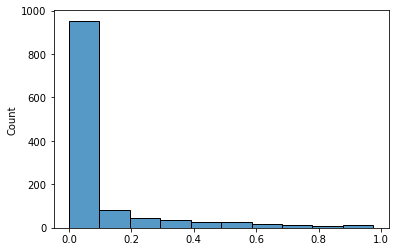

In [8]:
sns.histplot(values, bins=10)

In [9]:
nx.average_clustering(graph, weight='weight')

0.19810937605548143

In [10]:
nx.average_shortest_path_length(graph, weight='weight')

0.414347513700453

In [11]:
all_degrees = np.array([])
for cell_name, degree in graph.degree(weight='weight'):
    print('cell name: %s, degree: %f' % (cell_name, degree))
    all_degrees = np.append(all_degrees, degree)
    
np.mean(all_degrees)

cell name: C261, degree: 2.871624
cell name: C099, degree: 4.430680
cell name: C124, degree: 3.160695
cell name: C164, degree: 1.847410
cell name: C197, degree: 1.884957
cell name: C228, degree: 1.628725
cell name: C234, degree: 2.881478
cell name: C494, degree: 1.782323
cell name: C519, degree: 3.051440
cell name: C305, degree: 4.296911
cell name: C349, degree: 4.627324
cell name: C084, degree: 5.292025
cell name: C101, degree: 7.416878
cell name: C198, degree: 3.510162
cell name: C235, degree: 2.212364
cell name: C303, degree: 6.087265
cell name: C317, degree: 3.178839
cell name: C325, degree: 4.658793
cell name: C328, degree: 5.206471
cell name: C487, degree: 7.453283
cell name: C347, degree: 2.777286
cell name: C120, degree: 3.149575
cell name: C143, degree: 6.164275
cell name: C479, degree: 3.381751
cell name: C480, degree: 3.917094
cell name: C153, degree: 2.761335
cell name: C306, degree: 4.205592
cell name: C351, degree: 2.707771
cell name: C076, degree: 3.749166
cell name: C14

4.085195568853

In [12]:
print(nx.info(graph))

Name: 
Type: Graph
Number of nodes: 50
Number of edges: 272
Average degree:  10.8800


In [13]:
adjacency_matrix.sum().mean()

4.085195568852999

In [21]:
adjacency_matrix.mean().mean()

0.08170391137706

In [14]:
for base_cell, comp_cell, weight in graph.edges.data('length'):
    print('base cell: %s, compared cell: %s, length: %f' % (base_cell, comp_cell, weight))

base cell: C261, compared cell: C099, length: 4.750392
base cell: C261, compared cell: C124, length: 1.338402
base cell: C261, compared cell: C164, length: 2.059171
base cell: C261, compared cell: C197, length: 2.554049
base cell: C261, compared cell: C228, length: 3.442797
base cell: C261, compared cell: C234, length: 7.364140
base cell: C261, compared cell: C494, length: 2.697856
base cell: C261, compared cell: C519, length: 4.168942
base cell: C099, compared cell: C305, length: 2.651284
base cell: C099, compared cell: C349, length: 1.980911
base cell: C099, compared cell: C076, length: 2.215280
base cell: C099, compared cell: C084, length: 3.237225
base cell: C099, compared cell: C086, length: 1.801294
base cell: C099, compared cell: C124, length: 2.237274
base cell: C099, compared cell: C143, length: 3.705174
base cell: C099, compared cell: C198, length: 2.299672
base cell: C099, compared cell: C303, length: 2.444055
base cell: C099, compared cell: C310, length: 3.414427
base cell:

In [15]:
n = len(graph)
non_connected_cells = np.array([])
for base_cell in graph:
    for compared_cell in graph:
        if not nx.has_path(graph, base_cell, compared_cell):
            non_connected_cells = np.append(non_connected_cells, compared_cell)

In [31]:
count = 0
n = len(graph.nodes)
weight_sum = sum(weight for _, _, weight in graph.edges.data("weight"))
weight_sum / (n * (n - 1))

0.04168566906992857

In [32]:
len(graph.edges.data("weight")) / (n * (n - 1))

0.1110204081632653

In [18]:
np.nan > 0.0

False

In [19]:
data = pd.DataFrame({"デバイス":["デバイス A","デバイス B","デバイス A","デバイス A","デバイス C","デバイス C","デバイス B","デバイス C","デバイス A","デバイス A",], "出血量":[30,20,5,5,100,80,10,60,10,25]})

In [20]:
data

,デバイス,出血量
0,デバイス A,30
1,デバイス B,20
2,デバイス A,5
3,デバイス A,5
4,デバイス C,100
5,デバイス C,80
6,デバイス B,10
7,デバイス C,60
8,デバイス A,10
9,デバイス A,25


In [26]:
from networkx.algorithms.community import greedy_modularity_communities, girvan_newman

In [27]:
greedy_modularity_communities(graph, weight='weight')

[frozenset({'C000',
            'C007',
            'C009',
            'C059',
            'C076',
            'C084',
            'C086',
            'C099',
            'C101',
            'C116',
            'C120',
            'C124',
            'C141',
            'C143',
            'C145',
            'C153',
            'C164',
            'C173',
            'C175',
            'C197',
            'C198',
            'C228',
            'C234',
            'C235',
            'C261',
            'C284',
            'C303',
            'C305',
            'C306',
            'C310',
            'C317',
            'C325',
            'C327',
            'C328',
            'C336',
            'C347',
            'C349',
            'C351',
            'C362',
            'C377',
            'C442',
            'C459',
            'C476',
            'C479',
            'C480',
            'C487',
            'C491',
            'C493',
            'C494',
            'C519'})

In [28]:
girvan_newman(graph)

<generator object girvan_newman at 0x7fab1bd5fd60>

In [48]:
lengths = nx.all_pairs_dijkstra_path_length(graph)

In [49]:
lengths

<generator object all_pairs_dijkstra_path_length at 0x7fab1bd533c0>

In [50]:
length_values = []
for node, dic in lengths:
    print('source node is %s' % node)
    length_values += dic.values()
    
max(length_values)

source node is C261
source node is C099
source node is C124
source node is C164
source node is C197
source node is C228
source node is C234
source node is C494
source node is C519
source node is C305
source node is C349
source node is C084
source node is C101
source node is C198
source node is C235
source node is C303
source node is C317
source node is C325
source node is C328
source node is C487
source node is C347
source node is C120
source node is C143
source node is C479
source node is C480
source node is C153
source node is C306
source node is C351
source node is C076
source node is C141
source node is C284
source node is C442
source node is C491
source node is C000
source node is C007
source node is C059
source node is C116
source node is C173
source node is C175
source node is C362
source node is C377
source node is C476
source node is C009
source node is C086
source node is C145
source node is C310
source node is C459
source node is C327
source node is C336
source node is C493


1.0256309240548143